In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import t
from scipy.integrate import simps
import pymc3 as pm
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

## Xray/Edot

In [43]:
loudFile = open('RL_xray_Edot.txt','r')
XEdot_loud = loudFile.readline().split()
quietFile = open('RQ_xray_Edot.txt','r')
XEdot_quiet = quietFile.readline().split()

In [47]:
XEdot_quiet = np.array(map(float, XEdot_quiet))
XEdot_loud = np.array(map(float, XEdot_loud))

(array([ 15.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.]),
 array([  8.21485000e-13,   1.73603337e-10,   3.46385188e-10,
          5.19167040e-10,   6.91948891e-10,   8.64730743e-10,
          1.03751259e-09,   1.21029445e-09,   1.38307630e-09,
          1.55585815e-09,   1.72864000e-09]),
 <a list of 10 Patch objects>)

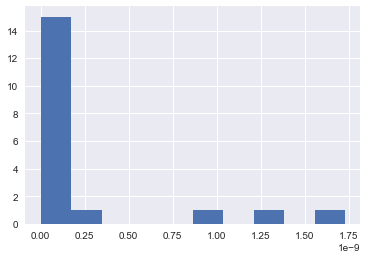

In [48]:
plt.hist(XEdot_quiet)

(array([ 24.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.41922000e-12,   7.46123298e-10,   1.49082738e-09,
          2.23553145e-09,   2.98023553e-09,   3.72493961e-09,
          4.46964369e-09,   5.21434777e-09,   5.95905184e-09,
          6.70375592e-09,   7.44846000e-09]),
 <a list of 10 Patch objects>)

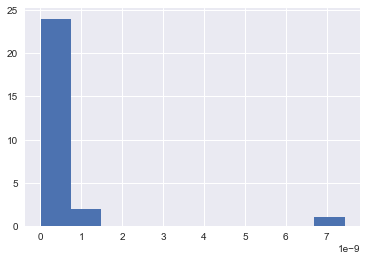

In [49]:
plt.hist(XEdot_loud)

In [50]:
log_XEdot_quiet = np.log10(XEdot_quiet)
log_XEdot_loud = np.log10(XEdot_loud)

(array([ 3.,  4.,  0.,  3.,  3.,  2.,  0.,  1.,  0.,  3.]),
 array([-12.08540036, -11.75308987, -11.42077938, -11.08846889,
        -10.75615839, -10.4238479 , -10.09153741,  -9.75922692,
         -9.42691643,  -9.09460593,  -8.76229544]),
 <a list of 10 Patch objects>)

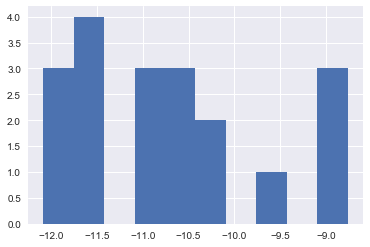

In [51]:
plt.hist(log_XEdot_quiet)

(array([ 4.,  5.,  5.,  3.,  2.,  3.,  2.,  2.,  0.,  1.]),
 array([-11.84795028, -11.4759486 , -11.10394692, -10.73194525,
        -10.35994357,  -9.98794189,  -9.61594022,  -9.24393854,
         -8.87193686,  -8.49993519,  -8.12793351]),
 <a list of 10 Patch objects>)

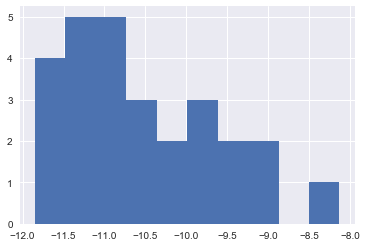

In [54]:
plt.hist(log_XEdot_loud)

In [57]:
log_XEdot = pd.DataFrame(dict(value=np.r_[log_XEdot_quiet, log_XEdot_loud], 
                          group=np.r_[['log_XEdot_quiet']*len(log_XEdot_quiet), ['log_XEdot_loud']*len(log_XEdot_loud)]))

In [60]:
mu_m = log_XEdot.value.mean()
mu_s = log_XEdot.value.std() * 2

sigma_low = log_XEdot.value.std() *0.1
sigma_high = log_XEdot.value.std() * 10

with pm.Model() as model_log_XEdot:
    quiet_mean = pm.Normal('quiet_mean', mu_m, sd=mu_s)
    loud_mean = pm.Normal('loud_mean', mu_m, sd=mu_s)
    
    quiet_std = pm.Uniform('quiet_std', lower=sigma_low, upper=sigma_high)
    loud_std = pm.Uniform('loud_std', lower=sigma_low, upper=sigma_high)
    
    nu = pm.Exponential('nu_minus_one', 1/29.) + 1
    
    quiet_lambda = quiet_std**-2
    loud_lambda = loud_std**-2
    
    quiet_group = pm.StudentT('quiet', nu=nu, mu=quiet_mean, lam=quiet_lambda, observed=log_XEdot_quiet)
    loud_group = pm.StudentT('loud', nu=nu, mu=loud_mean, lam=loud_lambda, observed=log_XEdot_loud)
    
    diff_of_means = pm.Deterministic('difference of means', quiet_mean - loud_mean)
    diff_of_stds = pm.Deterministic('difference of stds', quiet_std - loud_std)
    effect_size = pm.Deterministic('effect size', 
                                   diff_of_means / np.sqrt((quiet_std**2 + loud_std**2) / 2))

In [61]:
#db_log_XEdot = pm.backends.text.load('trace_log_XEdot', model=model_log_XEdot)
with model_log_XEdot:
    db_log_XEdot = pm.backends.Text('trace_log_XEdot')
    trace_log_XEdot = pm.sample(25000, tune=2000, trace=db_log_XEdot)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 27000/27000 [01:24<00:00, 320.49it/s]


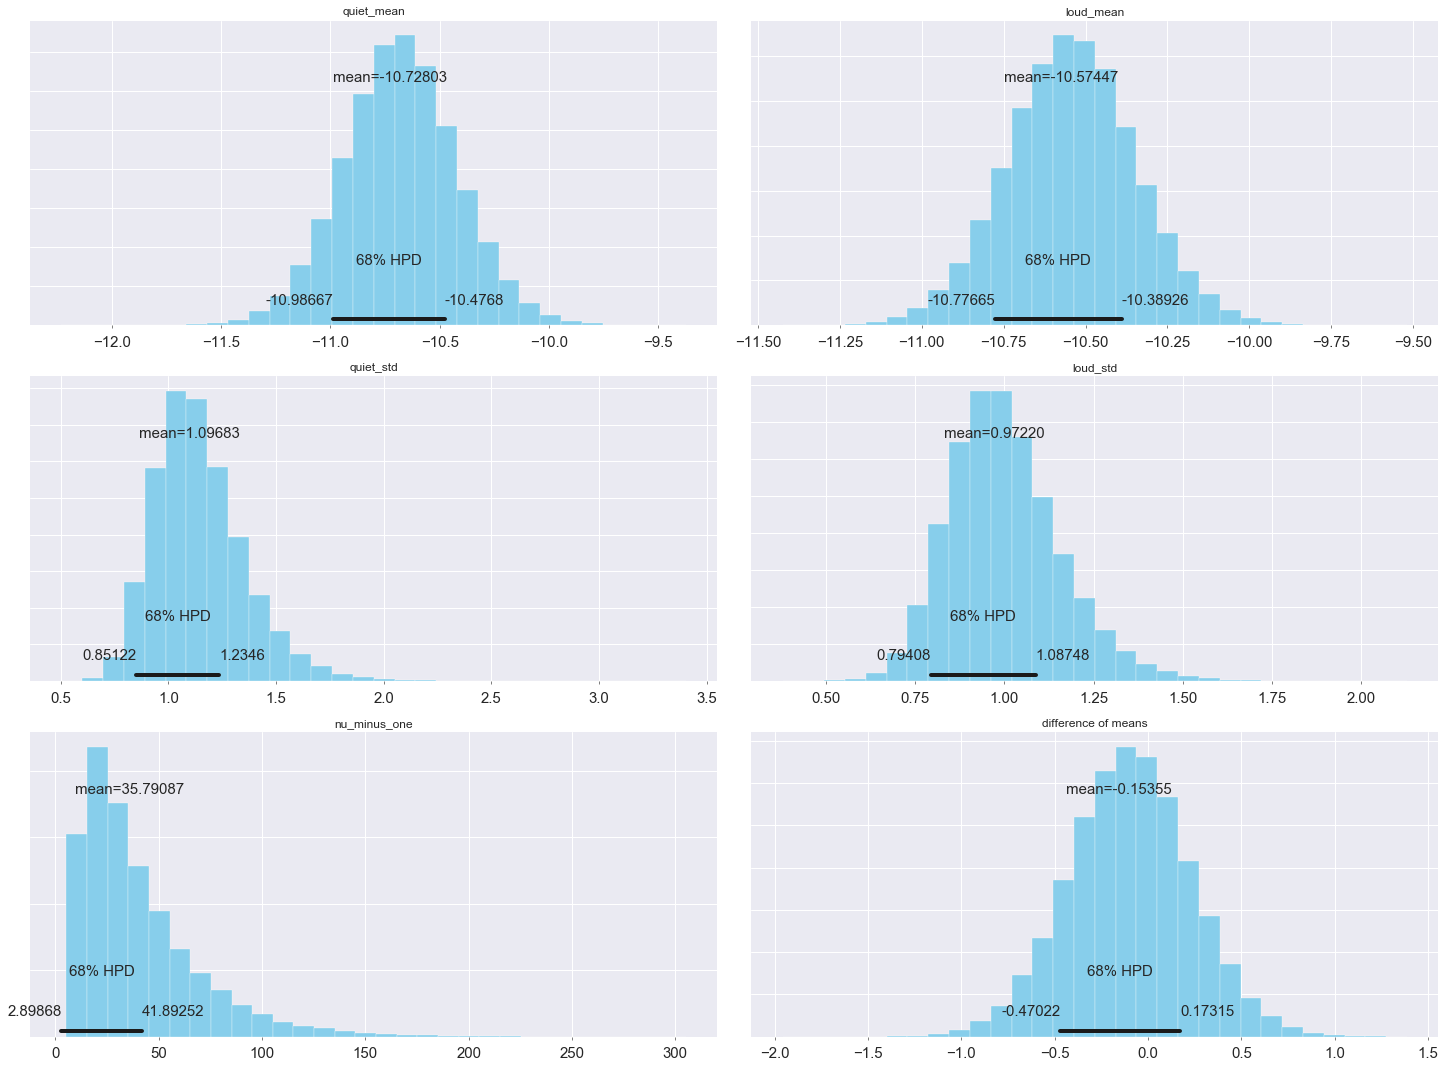

In [82]:
fig = pm.plot_posterior(trace_log_XEdot, varnames=['quiet_mean','loud_mean','quiet_std','loud_std','nu_minus_one','difference of means'], 
                  alpha_level=0.32, figsize=(20, 15), text_size=15, round_to=5, color='#87ceeb')
#plt.savefig('trace_log_XEdot.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

## Gamma/Edot

In [67]:
loudFile = open('RL_gamma_Edot.txt','r')
GEdot_loud = loudFile.readline().split()
quietFile = open('RQ_gamma_Edot.txt','r')
GEdot_quiet = quietFile.readline().split()

In [68]:
GEdot_quiet = np.array(map(float, GEdot_quiet))
GEdot_loud = np.array(map(float, GEdot_loud))

(array([ 3.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 0.01870648,  0.19543232,  0.37215816,  0.54888401,  0.72560985,
         0.9023357 ,  1.07906154,  1.25578738,  1.43251323,  1.60923907,
         1.78596491]),
 <a list of 10 Patch objects>)

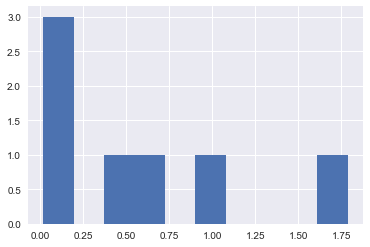

In [69]:
plt.hist(GEdot_quiet)

(array([ 29.,   7.,   1.,   1.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([  8.69507000e-04,   1.75752970e-01,   3.50636434e-01,
          5.25519897e-01,   7.00403361e-01,   8.75286825e-01,
          1.05017029e+00,   1.22505375e+00,   1.39993722e+00,
          1.57482068e+00,   1.74970414e+00]),
 <a list of 10 Patch objects>)

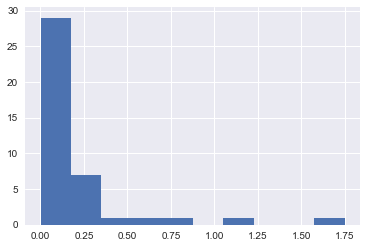

In [71]:
plt.hist(GEdot_loud)

In [72]:
log_GEdot_quiet = np.log10(GEdot_quiet)
log_GEdot_loud = np.log10(GEdot_loud)

(array([ 1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.]),
 array([-1.72800797, -1.53001988, -1.33203179, -1.1340437 , -0.93605561,
        -0.73806753, -0.54007944, -0.34209135, -0.14410326,  0.05388483,
         0.25187292]),
 <a list of 10 Patch objects>)

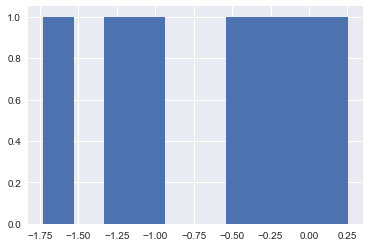

In [73]:
plt.hist(log_GEdot_quiet)

(array([ 4.,  2.,  3.,  4.,  4.,  8.,  4.,  8.,  2.,  2.]),
 array([-3.06072692, -2.73035776, -2.39998861, -2.06961946, -1.7392503 ,
        -1.40888115, -1.07851199, -0.74814284, -0.41777369, -0.08740453,
         0.24296462]),
 <a list of 10 Patch objects>)

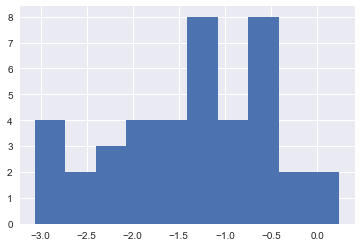

In [74]:
plt.hist(log_GEdot_loud)

In [75]:
log_GEdot = pd.DataFrame(dict(value=np.r_[log_GEdot_quiet, log_GEdot_loud], 
                          group=np.r_[['log_GEdot_quiet']*len(log_GEdot_quiet), ['log_GEdot_loud']*len(log_GEdot_loud)]))

In [76]:
mu_m = log_GEdot.value.mean()
mu_s = log_GEdot.value.std() * 2

sigma_low = log_GEdot.value.std() *0.1
sigma_high = log_GEdot.value.std() * 10

with pm.Model() as model_log_GEdot:
    quiet_mean = pm.Normal('quiet_mean', mu_m, sd=mu_s)
    loud_mean = pm.Normal('loud_mean', mu_m, sd=mu_s)
    
    quiet_std = pm.Uniform('quiet_std', lower=sigma_low, upper=sigma_high)
    loud_std = pm.Uniform('loud_std', lower=sigma_low, upper=sigma_high)
    
    nu = pm.Exponential('nu_minus_one', 1/29.) + 1
    
    quiet_lambda = quiet_std**-2
    loud_lambda = loud_std**-2
    
    quiet_group = pm.StudentT('quiet', nu=nu, mu=quiet_mean, lam=quiet_lambda, observed=log_GEdot_quiet)
    loud_group = pm.StudentT('loud', nu=nu, mu=loud_mean, lam=loud_lambda, observed=log_GEdot_loud)
    
    diff_of_means = pm.Deterministic('difference of means', quiet_mean - loud_mean)
    diff_of_stds = pm.Deterministic('difference of stds', quiet_std - loud_std)
    effect_size = pm.Deterministic('effect size', 
                                   diff_of_means / np.sqrt((quiet_std**2 + loud_std**2) / 2))

In [77]:
#db_log_GEdot = pm.backends.text.load('trace_log_GEdot', model=model_log_GEdot)
with model_log_GEdot:
    db_log_GEdot = pm.backends.Text('trace_log_GEdot')
    trace_log_GEdot = pm.sample(25000, tune=2000, trace=db_log_GEdot)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 27000/27000 [01:06<00:00, 403.13it/s]


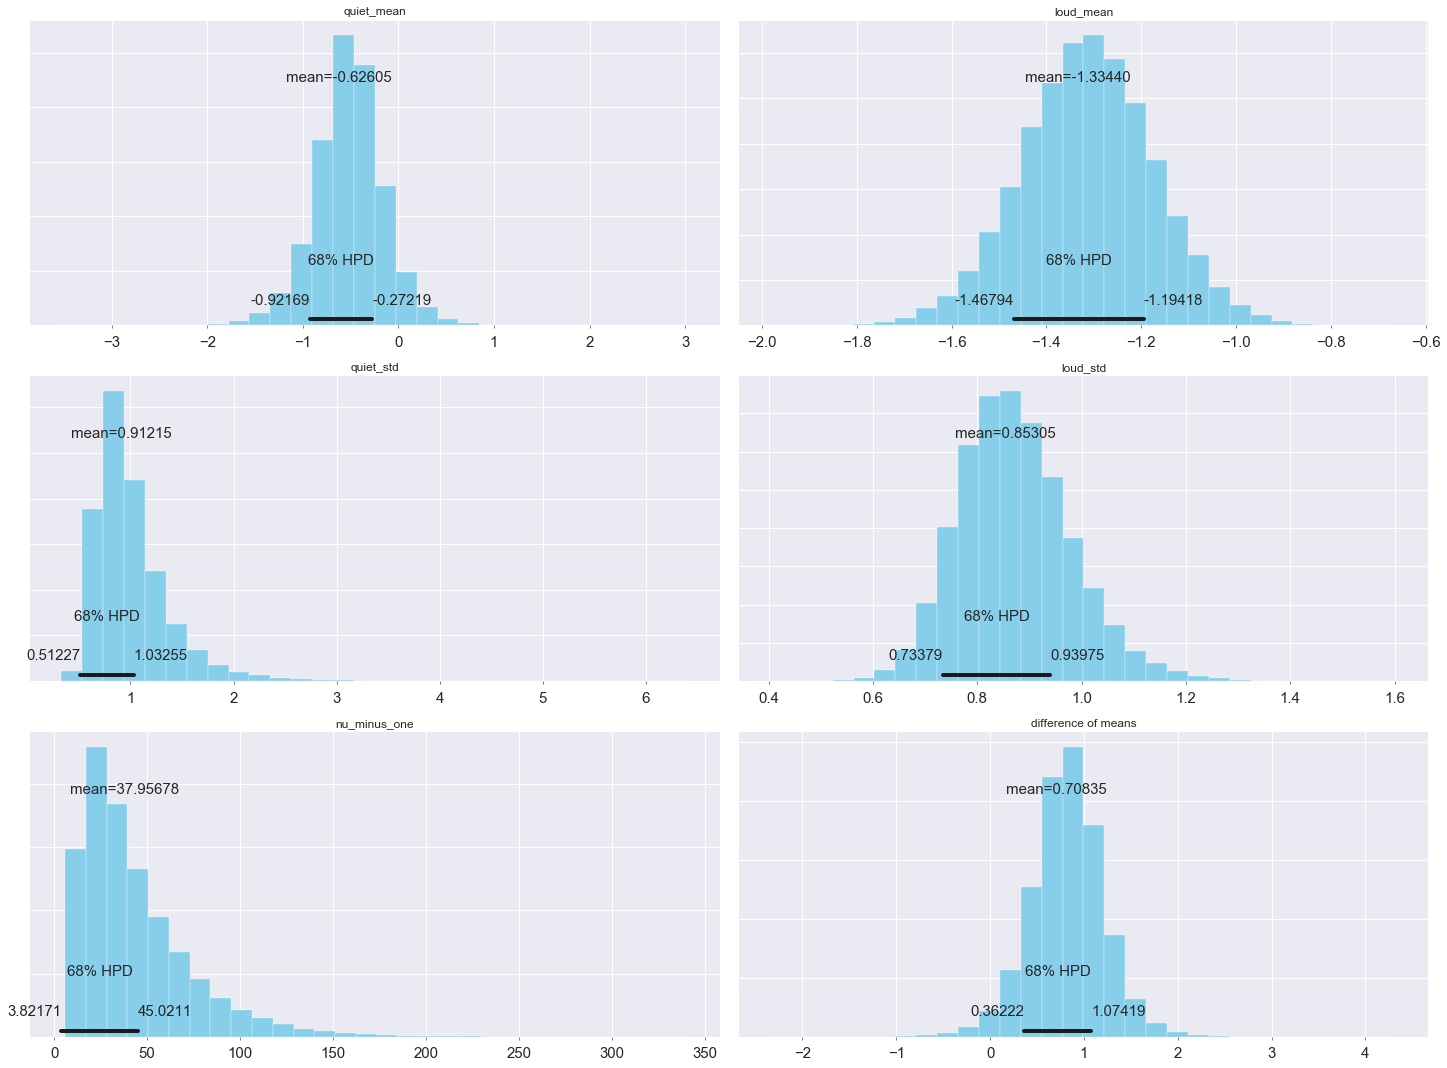

In [81]:
fig = pm.plot_posterior(trace_log_GEdot, varnames=['quiet_mean','loud_mean','quiet_std','loud_std','nu_minus_one','difference of means'], 
                  alpha_level=0.32, figsize=(20, 15), text_size=15, round_to=5, color='#87ceeb')
#plt.savefig('trace_log_GEdot.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)